# Problem 2: Azure Cognitive service
- 실내에서 마스크를 착용하는지 확인하는 인공지능 모델 생성
- 주어진 데이터셋을 활용하여, 마스크 Object를 학습하고 탐지하는 모델 생성

## Part 1 : Image Analysis 로 캡섭 및 분석을 출력

In [5]:
cog_key = '149b9a076c7d48dd98f306cec2e540c4'
cog_endpoint = 'https://ai-900-kwcgs.cognitiveservices.azure.com/'

print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))

Ready to use cognitive services at https://ai-900-kwcgs.cognitiveservices.azure.com/ using key 149b9a076c7d48dd98f306cec2e540c4


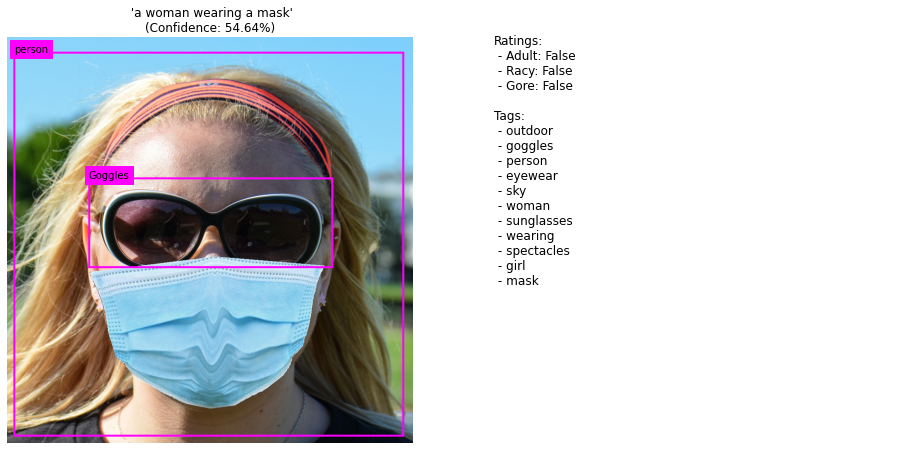

In [6]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
from python_code import vision
import os
%matplotlib inline
# Get the path to an image file
image_path = os.path.join('data', 'mask_dataset', 'mask_train25.jpg')

# Get a client for the computer vision service
computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

# Specify the features we want to analyze
features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']

# Get an analysis from the computer vision service
image_stream = open(image_path, "rb")
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)

# Show the results of analysis (code in helper_scripts/vision.py)
vision.show_image_analysis(image_path, analysis)

## Part 2 : 마스크를 감지하여 나타냄

In [2]:
project_id = 'cfa01c71-e164-4f3b-93dd-7fb2c222ca89' # Replace with your project ID
cv_key = '685bc525308c480ba25dcbcac56bcf18' # Replace with your prediction resource primary key
cv_endpoint = 'https://ai900kwcvtemp3-prediction.cognitiveservices.azure.com/' # Replace with your prediction resource endpoint

model_name = 'mask_detection' # this must match the model name you set when publishing your model iteration exactly (including case)!
print('Ready to predict using model {} in project {}'.format(model_name, project_id))

Ready to predict using model mask_detection in project cfa01c71-e164-4f3b-93dd-7fb2c222ca89


Detecting objects in data/mask_dataset/mask_train19.jpg using model mask_detection in project cfa01c71-e164-4f3b-93dd-7fb2c222ca89...


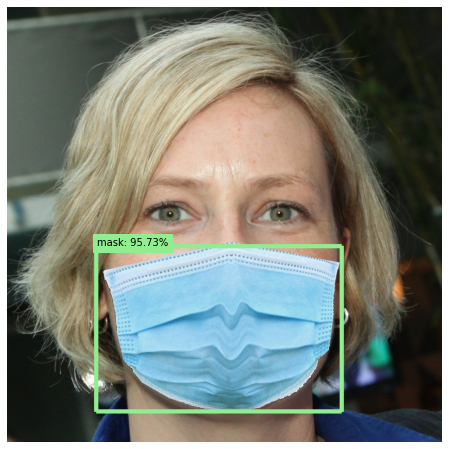

In [3]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
%matplotlib inline

# Load a test image and get its dimensions
test_img_file = os.path.join('data', 'mask_dataset', 'mask_train19.jpg')
test_img = Image.open(test_img_file)
test_img_h, test_img_w, test_img_ch = np.array(test_img).shape

# Get a prediction client for the object detection model
credentials = ApiKeyCredentials(in_headers={"Prediction-key": cv_key})
predictor = CustomVisionPredictionClient(endpoint=cv_endpoint, credentials=credentials)

print('Detecting objects in {} using model {} in project {}...'.format(test_img_file, model_name, project_id))

# Detect objects in the test image
with open(test_img_file, mode="rb") as test_data:
    results = predictor.detect_image(project_id, model_name, test_data)

# Create a figure to display the results
fig = plt.figure(figsize=(8, 8))
plt.axis('off')

# Display the image with boxes around each detected object
draw = ImageDraw.Draw(test_img)
lineWidth = int(np.array(test_img).shape[1]/100)
object_colors = {
    "mask": "lightgreen"
}
for prediction in results.predictions:
    color = 'white' # default for 'other' object tags
    if (prediction.probability*100) > 50:
        if prediction.tag_name in object_colors:
            color = object_colors[prediction.tag_name]
        left = prediction.bounding_box.left * test_img_w 
        top = prediction.bounding_box.top * test_img_h 
        height = prediction.bounding_box.height * test_img_h
        width =  prediction.bounding_box.width * test_img_w
        points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
        draw.line(points, fill=color, width=lineWidth)
        plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top), backgroundcolor=color)
plt.imshow(test_img)
